In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

util_path = os.path.abspath(os.path.join('../utilities')) 

if util_path not in sys.path:
    sys.path.append(util_path)
    
from python.plotting import *

In [3]:
# matplotlib settings

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

## Generate panels related to Fig 2 

Inferred differential activity of TFs and RBPs relative to expression levels in iNeurons.

## Data

In [4]:
data_loc = '../data/supp_tables'

table_s1 = pd.read_csv(f'{data_loc}/table_S1_de_ds_ineurons.tsv', sep = '\t')
splicing_compendium = pd.read_csv(f'{data_loc}/table_S6_splicing_compendium.tsv', sep = '\t')
table_tfs = pd.read_csv(f'{data_loc}/table_S7_inferred_tf_activity.tsv', sep = '\t')
table_rbps = pd.read_csv(f'{data_loc}/table_S9_inferred_rbps.tsv', sep = '\t')

In [11]:
# Also full DE results for transcripts
de_genes = pd.read_csv('../data/de_ds_ineurons/ipsc_tdp43_kd_deseq2_differential_gene_expression_nodups.csv',
                      index_col = 0)

In [13]:
# Annotated CLIP data from postar3

tdp43_neuron_annotated = pd.read_csv('../data/clip/tdp43_neuron_sites_annotated.txt', sep = '\t')

# drop the intergenic regions which can't be properly mapped
tdp43_neuron_annotated['simple_annotation'] = tdp43_neuron_annotated.apply(lambda row: row['Annotation'].split('(')[0],
                                                                          axis = 1)

tdp43_neuron_annotated = tdp43_neuron_annotated[tdp43_neuron_annotated.simple_annotation != 'Intergenic']

# Get all unique genes with evidence of binding
tdp43_neuron_annotated_genes = pd.unique(tdp43_neuron_annotated['Gene Name'].values)
tdp43_neuron_annotated_genes

array(['BRF1', 'PDS5A', 'WNT7A', ..., 'ZNF394', 'CDH10', 'ME2'],
      dtype=object)

### Plotting TFs

In [21]:
tf_deg_merged = table_tfs.merge(de_genes, left_on = 'TF', right_on = 'gene_name')


# get TFs to label -- those with sign DA and evidence of regulation by TDP-43

da_tfs = tf_deg_merged[tf_deg_merged.inferred_DA].TF.values
print(len(da_tfs))

da_tfs_cryptic = set(da_tfs).intersection(splicing_compendium[splicing_compendium.num_datasets_cryptic > 0].gene_name.values)
print(len(da_tfs_cryptic))

da_tfs_ds = set(da_tfs).intersection(splicing_compendium[splicing_compendium.num_datasets_misspliced > 0].gene_name.values)
print(len(da_tfs_ds))

da_tfs_apa = set(da_tfs).intersection(splicing_compendium[splicing_compendium.num_datasets_C_APA > 0].gene_name.values)
print(len(da_tfs_apa))

da_tfs_binding = set(da_tfs).intersection(tdp43_neuron_annotated_genes)
print(len(da_tfs_binding))

26
5
6
7
16


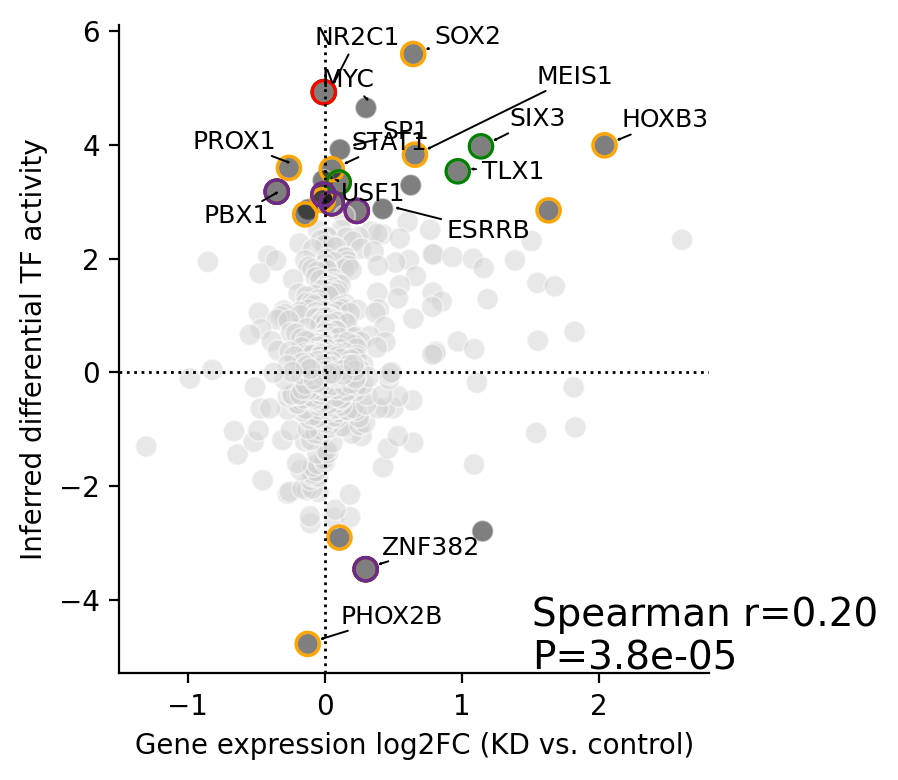

In [38]:
# Plot inferred activity vs log2FC of gene expression
custom_palette = {False: 'lightgrey',
                 True: 'black'
                 }

highlight_dict = {
    
    'Has TDP-43 RNA binding': (list(da_tfs_binding),'orange'),
    'Has AP': (list(da_tfs_apa), 'green'),
    'Has DS': (list(da_tfs_ds), 'red'),
    'Has cryptic': (list(da_tfs_cryptic), '#662D91'),
}


label_genes = table_tfs.head(15).TF.values.tolist() + ['ESRRB', 'PBX1']


g = facet_scatterplot(
    df=tf_deg_merged,
    x_col='log2FoldChange',
    y_col='inferred_activity',
    hue_col='inferred_DA',
    palette=custom_palette,
    sharey=True,            
    sharex = True,
    dotted_axes=True,        
    correlation='spearman',  # add Spearman correlation text
    highlight_dict=highlight_dict,
    label_genes=label_genes, # label selected genes
    use_adjust_text=True,
    label_fontsize=9,
    remove_facet_titles = False,
    single_facet_color='grey',
    dpi=200,
    corr_location=(0.7, 0.12),
    aspect = 1.1,
    annotate_num_points=False, 
    legend=False,
    height = 4,
    alpha = 0.5
)
g.set_axis_labels('Gene expression log2FC (KD vs. control)', 'Inferred differential TF activity' )


# plt.savefig('fig2_scatter_TFs_v2.pdf', format='pdf', dpi=300, bbox_inches='tight')
# plt.savefig('fig2_scatter_TFs_v2.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

### Plotting RBPs

In [31]:
# Get all RBPs from POSTAR3 and ATTRACT databases
rbps_postar_attract = pd.read_csv('../data/clip/rbps_postar_attract.txt', names = ['rbp'])


In [35]:
rbp_de_merged = rbps_postar_attract.merge(table_s1, left_on = 'rbp', right_on = 'gene_name')

rbp_de_merged['inferred_RBP'] = rbp_de_merged.gene_name.isin(table_rbps.associated_gene.unique())


# get RBPs to label -- those with sign DA and evidence of regulation by TDP-43

da_rbps = rbp_de_merged[rbp_de_merged.inferred_RBP].gene_name.values
print(len(da_rbps))

da_rbps_cryptic = set(da_rbps).intersection(splicing_compendium[splicing_compendium.num_datasets_cryptic > 0].gene_name.values)
print(len(da_rbps_cryptic))

da_rbps_ds = set(da_rbps).intersection(splicing_compendium[splicing_compendium.num_datasets_misspliced > 0].gene_name.values)
print(len(da_rbps_ds))

da_rbps_apa = set(da_rbps).intersection(splicing_compendium[splicing_compendium.num_datasets_C_APA > 0].gene_name.values)
print(len(da_rbps_apa))

da_rbps_binding = set(da_rbps).intersection(tdp43_neuron_annotated_genes)
print(len(da_rbps_binding))

41
12
15
5
32


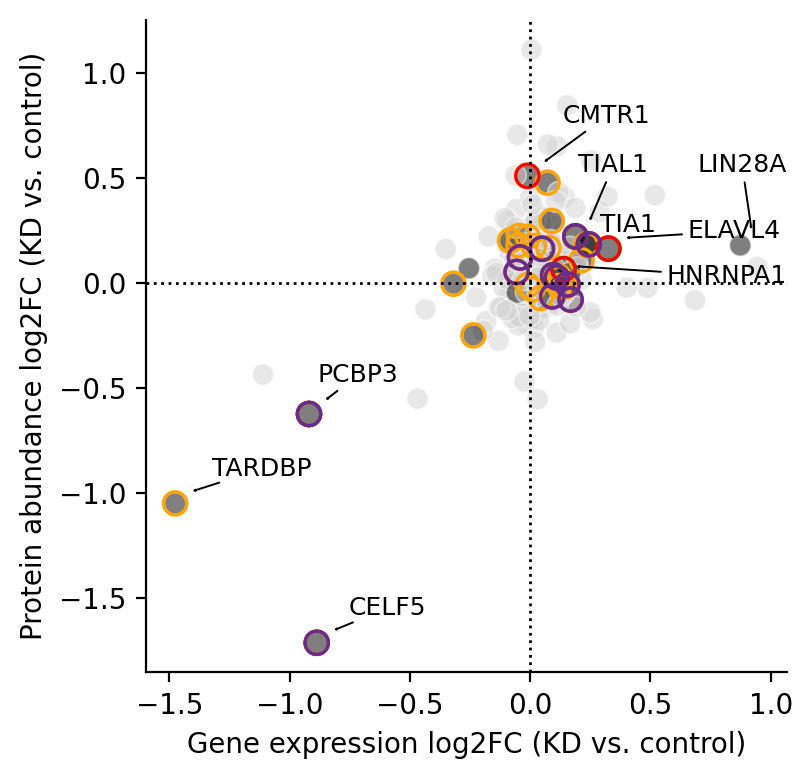

In [39]:
# Plot protein expression vs gene expression for RBPs
# Can more easily see which ones affected on both transcript and protein level

custom_palette = {False: 'lightgrey',
                 True: 'black'
                 }

highlight_dict = {
    
    'Has TDP-43 RNA binding': (list(da_rbps_binding),'orange'),
    'Has AP': (list(da_rbps_apa), 'green'),
    'Has DS': (list(da_rbps_ds), 'red'),
    'Has cryptic': (list(da_rbps_cryptic), '#662D91'),
}


label_genes = ['CELF5', 'TARDBP', 'TIA1', 'TIAL1', 'PCBP3', 'LIN28A', 'HNRNPA1', 'ELAVL4', 'PPIE', 'CMTR1']


g = facet_scatterplot(
    df=rbp_de_merged,
    x_col='log2FC_rna',
    y_col='log2FC_prot',
    hue_col='inferred_RBP',
    palette=custom_palette,
    sharey=True,            
    sharex = True,
    dotted_axes=True,        
#     correlation='spearman',  # add Spearman correlation text
    highlight_dict=highlight_dict,
    label_genes=label_genes, # label selected genes
    use_adjust_text=True,
    label_fontsize=9,
    remove_facet_titles = False,
    single_facet_color='grey',
    dpi=200,
    corr_location=(0.7, 0.12),
    aspect = 1.1,
    annotate_num_points=False, 
    legend=False,
    height = 4,
    alpha = 0.5
)
g.set_axis_labels('Gene expression log2FC (KD vs. control)', 'Protein abundance log2FC (KD vs. control)')

# plt.savefig('fig2_scatter_RBPs_v2.pdf', format='pdf', dpi=300, bbox_inches='tight')
# plt.savefig('fig2_scatter_RBPs_v2.png', format='png', dpi=300, bbox_inches='tight')

plt.show()